In [37]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges
from dm21cm.interpolators_jax import BatchInterpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory
import darkhistory.physics as dh_phys
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
print(darkhistory.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

1.0.0-dm21cm.0


In [2]:
tf_name = 'zf01'
abscs = load_h5_dict(f"{WDIR}/data/abscissas/abscs_{tf_name}.h5")

## dm21cm_tf

In [3]:
dc_dep_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_dep.h5")
dc_scat_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_scat.h5")

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


In [4]:
# inject 1 electron
spec_N = np.zeros((500,))
i_injE = 428
spec_N[i_injE] = 1.
elecEk = dc_dep_tf.abscs['Ein']
injE = np.dot(spec_N, elecEk + phys.m_e)
print(f'total energy = {injE} eV')

total energy = 83739425895.51418 eV


In [5]:
rs = 38.71318413405634
xe = 0.01
nBs = 1.00

In [6]:
f_dc = dc_dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / injE

f_dc = np.array(f_dc).flatten()
print(f_dc)

[2.01992568e-04 7.51701330e-06 1.16720376e-04 2.65018597e-04
 4.47264396e-05 1.44980023e-03]


In [7]:
sec_phot_N = dc_scat_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
)
f_phot_dc = np.dot(sec_phot_N, abscs['photE']) / injE

In [8]:
print(np.sum(f_dc[:5]) + f_phot_dc)

[0.99826208]


## DH_run

In [9]:
tf_version = 'zf01'

dh_load_data('dep_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}")
dh_load_data('ics_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}");

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1/../DHdata_v1_1_zf01
    for propagating photons...  

 Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [34]:
soln = dh_evolve(
    DM_process='swave', mDM=injE, sigmav=1e-25, primary='elec_delta', # sigmav shouldn't matter
    start_rs=rs, end_rs=rs/1.01,
    coarsen_factor=12, backreaction=True,
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    cross_check_21cmfast=True,
)

Loading time: 0.000 s
Initialization time: 0.164 s
lowengelec_spec_at_rs 6.60701759396625e-07
deposited_ion 3.0030464294435683e-07
deposited_exc 2.706509256834677e-07
deposited_heat 1.0477295460557059e-07
deposited_ICS -1.5135007939054278e-10
ics_phot_spec 0.999992561470656
positronium_phot_spec 6.471144598132749e-06
highengphot_spec_at_rs 0.9999990326152541
f_raw =  (array([2.83421409e-04, 1.06935355e-05, 1.63052315e-04, 3.76031093e-04,
       1.53390907e-04]), array([ 3.95245993e-06,  0.00000000e+00,  3.02912143e-06,  9.87232123e-07,
       -1.40701590e-08]))
-----------
lowengelec_spec_at_rs 1.3888605924077112e-05
deposited_ion 3.0346918347160794e-07
deposited_exc 2.735012048370437e-07
deposited_heat 9.177287570848911e-08
deposited_ICS -1.5114067844864666e-10
ics_phot_spec 0.9999925618958464
positronium_phot_spec 6.471144598132748e-06
highengphot_spec_at_rs 1.998853343547113
f_raw =  (array([3.47742539e-04, 1.30405528e-05, 2.04267520e-04, 4.32672683e-04,
       2.58636828e-04]), arr

In [22]:
f_dh = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
f_dh = f_dh[:,0]

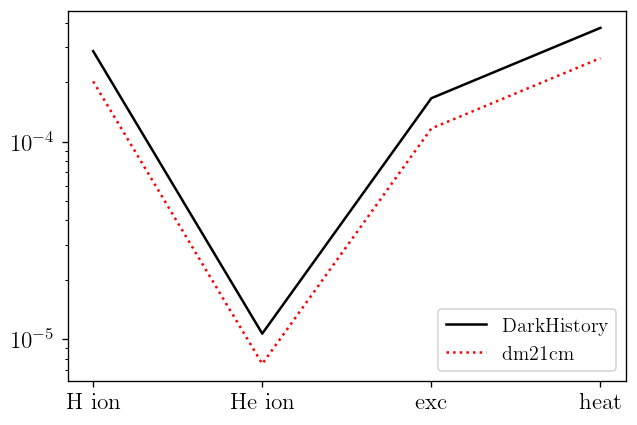

In [23]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()

ax.plot(f_dh[:4], label='DarkHistory', color='k')
ax.plot(f_dc[:4], label='dm21cm', color='r', ls=':')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dc_dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

In [24]:
f_dc[:4] / f_dh[:4]

array([0.70289121, 0.7029493 , 0.70279002, 0.70293293])

In [43]:
inj_rate = dh_phys.inj_rate('swave', rs, mDM=injE, sigmav=1e-25)

In [45]:
dts = np.load(os.environ['DM21CM_DATA_DIR'] + f"/tf/{tf_version}/phot/dt_rxneo.npy")
dt = np.interp(rs, abscs['rs'], dts[:,1])
soln['highengphot'][0].toteng() / (inj_rate/phys.n_B/rs**3 * dt)

0.999999032615254

In [ ]:
sec_phot_N

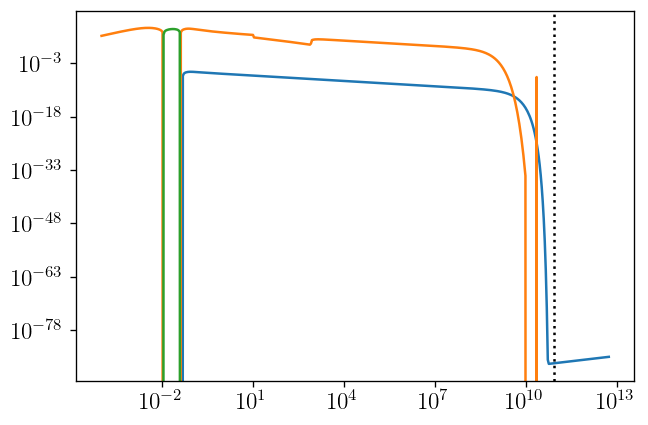

In [69]:
plt.plot(abscs['photE'], soln['highengphot'][0].N / (inj_rate/phys.n_B/rs**3 * dt))
plt.plot(abscs['photE'], np.array(sec_phot_N[0]))
plt.plot(abscs['photE'], -np.array(sec_phot_N[0]))
plt.axvline(injE, color='k', ls=':')
plt.xscale('log')
plt.yscale('log')

In [67]:
np.dot(sec_phot_N[0], abscs['photE']) / injE

0.9976261030503204

In [29]:
soln['lowengelec'][1].toteng() / injE

2.4344751532197163e-21

In [ ]:
f_phot_dh = soln['highengphot']

In [30]:
binning = dh_load_data('binning')
print(np.min(binning['elec']))

1.029782576544676


[autoreload of darkhistory.main failed: Traceback (most recent call last):
  File "/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/home07/yitians/darkhistory/DarkHistory/darkhistory

## 21 run

In [188]:
from dm21cm.evolve import evolve

In [192]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 2*(photeng[i_injE]+0.1),
    lifetime = 1e25,
)

return_dict = evolve(
    run_name = 'dhc_test',
    z_start = 38.2,
    z_end = 4.96266792,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = 'zf01',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='../run_info',
    debug_dhc_DH_xe_func=lambda z: 0.01,
    debug_dhc_delta_fixed=True,
    debug_no_bath=True,
    debug_use_tf_dt=True,
)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca.d20230929
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test


INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 9292.31412387332 0.23165742133748876
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -9.587479e-02
zp = 3.810032e+01
dt_dzp = -8.572903e+13
dadia_dzp * dzp = -1.478124e-01
dspec_dzp * dzp = 0.000000e+00
dcomp_dzp * dzp = 7.661585e-03
dxheat_dzp * dzp = 0.000000e+00
input heating = 0.000000e+00
dxion_source = 0.000000e+00
dxion_sink = 7.227056e-08
T = 3.014094e+01
alpha_A(T) = 1.790334e-11
global_params.CLUMPING_FACTOR = 1.000000e+00
x_e = 2.078851e-04
f_H = 9.249617e-01
prefactor_1 = 1.228640e-02
curr_delNL0 = -1.830332e-06
growth_factor_zp = 3.256493e-02
input ionization = 0.000000e+00

N_b0 = 2.055340e-07
f_H = 9.249617e-01

dt 33356785139759.77 33677476183046.547
before 9292.313 0.23165745
input_heating 1.0119549e-07
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -3.871307e-01
zp = 3.771318e+01
dt_dzp = -8.788830e+13
dadia_dzp * dzp = -1.858458e+02
dspec_dzp * dzp =

In [197]:
run_name = 'dhc_test'
soln = np.load(f"../run_info/{run_name}_records.npy", allow_pickle=True).item()
np.array([soln['f_ion'][2], soln['f_exc'][2], soln['f_heat'][2]]) / np.array([f_dh[0] + f_dh[1], f_dh[2], f_dh[3]])

array([0.99999976, 0.9999999 , 0.99999986])

## A. HED pipeline

In [110]:
# .npy
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot"
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
hed_tfgv[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [111]:
# dm21cm tf
tf = np.load(f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot/hed_tf_rxneo.npy")
tf[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [134]:
# dhtf
dhtf = pickle.load(open(f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_zf01/highengdep_interp.raw", 'rb'))
dhtf.grid_vals[0][3, 0, 8, 429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [135]:
dhtf.get_val(0.01, 0.9, abscs['rs'][-2])[429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

correct!!